In [1]:
from IPython.display import Image, Video
from agents import *
from utils import EpsilonGreedy
from utils.agent_metrics_comparer import AgentMetricsComparer
import pandas as pd

2024-11-13 21:23:13.354927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 21:23:13.363669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 21:23:13.372856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 21:23:13.375700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 21:23:13.383253: I tensorflow/core/platform/cpu_feature_guar

## Libs

- numpy
- matplotlib
- gymnasium (openai gym)
- moviepy (for recording video of agent playing)
- tensorflow / tensorflow[and-cuda]

## Documentations / References.

Documentation on gym / gymnasium can be found here: [https://gymnasium.farama.org/api/env/], it has good documentation on all the functions. - Do not use the one "showed" in exam paper: [https://www.gymlibrary.dev/index.html], since it has pretty bad documentation.

# [TASK-1] Overview of the Environment.

## Grid

The taxi can move on all nodes except $X$.

For each step it takes, it will be given $-1$ rewards, if successfully deliver passenger $+20$ reward points is granted. On failure on pickup and dropoff $-10$ reward points are granted.

$$
\begin{bmatrix}
\text{RED}_{11} & x_{12} & \text{X} & x_{14} & \text{GREEN}_{15} \\
x_{21} & x_{22} & \text{X} & x_{24} & x_{25} \\
x_{31} & x_{32} & x_{33} & x_{34} & x_{35} \\
x_{41} & \text{X} & x_{43} & x_{44} & x_{45} \\
\text{YELLOW}_{51} & \text{X} & x_53 & \text{BLUE}_{54} & x_{55}
\end{bmatrix}
$$

## Actions
0: move south

1: move north

2: move east

3: move west

4: pickup passenger

5: drop off passenger

## Observation space.

The taxi can dropoff passanger on (0)$\text{RED}_{11}$, (1)$\text{GREEN}_{15}$, (2)$\text{YELLOW}_{51}$, (3)$\text{BLUE}_{54}$.
That means that the passanger can be on all these states, and additionally (4)$\text{in taxi}$.

The grid is **5x5** resulting in **25** different locations for the taxi.

$4_{destinations} * 5_{passanger_locations} * 25_{nodes} = 500_{states}$

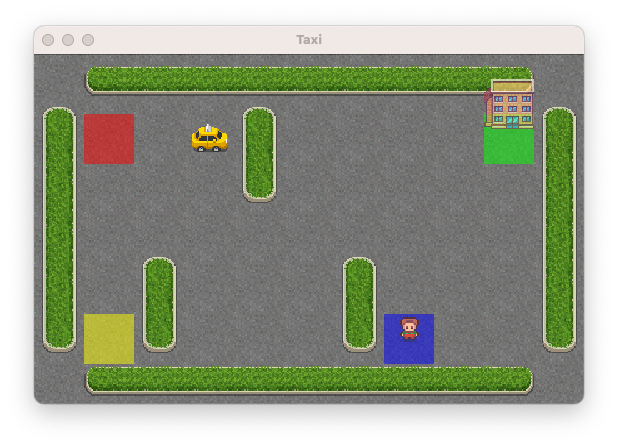

In [2]:
Image(filename='./static/Environment.png')

# Hyperparameter Discovery

In [3]:
basic_params = pd.read_csv('./static/metrics/basic_tune_metrics.csv')
sarsa_params = pd.read_csv('./static/metrics/sarsa_tune_metrics.csv')

In [4]:
basic_params.describe()

,epsilon_decay,learning_rate,discount_factor,score_min,score_avg,score_max,step_min,step_avg,step_max,time_min,time_avg,time_max
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000
mean,0.826428,0.714423,0.777104,-789.410000,-18.809303,14.975000,6.025000,31.893423,200.0,0.000047,0.000227,0.001590
std,0.036342,0.143631,0.174413,60.005208,16.477967,0.353553,0.353553,13.629906,0.0,0.000003,0.000094,0.000059
min,0.800062,0.101503,0.100295,-929.000000,-162.588000,10.000000,6.000000,27.202000,200.0,0.000045,0.000191,0.001439
25%,0.807165,0.724437,0.773639,-830.000000,-16.318667,15.000000,6.000000,27.698667,200.0,0.000046,0.000196,0.001554
50%,0.813305,0.769243,0.833918,-794.000000,-13.822333,15.000000,6.000000,28.236333,200.0,0.000046,0.000201,0.001574
75%,0.826992,0.788406,0.872260,-749.000000,-13.113500,15.000000,6.000000,29.799500,200.0,0.000047,0.000213,0.001613
max,0.996316,0.799971,0.986995,-650.000000,-12.508000,15.000000,11.000000,164.316000,200.0,0.000079,0.001138,0.001840


In [5]:
basic_params.corr()

,epsilon_decay,learning_rate,discount_factor,score_min,score_avg,score_max,step_min,step_avg,step_max,time_min,time_avg,time_max
epsilon_decay,1.000000,-0.203730,-0.290373,-0.130367,-0.311869,-0.093099,0.093099,0.180671,NaN,0.213742,0.207548,0.215150
learning_rate,-0.203730,1.000000,0.255490,-0.032103,0.796768,0.291485,-0.291485,-0.816154,NaN,-0.293421,-0.821377,-0.217294
discount_factor,-0.290373,0.255490,1.000000,-0.017160,0.315679,0.273437,-0.273437,-0.369904,NaN,-0.333053,-0.385471,-0.239833
score_min,-0.130367,-0.032103,-0.017160,1.000000,0.057650,-0.015882,0.015882,-0.001950,NaN,-0.003553,-0.001899,-0.069766
score_avg,-0.311869,0.796768,0.315679,0.057650,1.000000,0.620087,-0.620087,-0.960955,NaN,-0.535721,-0.960348,-0.120216
score_max,-0.093099,0.291485,0.273437,-0.015882,0.620087,1.000000,-1.000000,-0.690448,NaN,-0.856041,-0.687293,0.043248
step_min,0.093099,-0.291485,-0.273437,0.015882,-0.620087,-1.000000,1.000000,0.690448,NaN,0.856041,0.687293,-0.043248
step_avg,0.180671,-0.816154,-0.369904,-0.001950,-0.960955,-0.690448,0.690448,1.000000,NaN,0.597305,0.997122,0.111957
step_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_min,0.213742,-0.293421,-0.333053,-0.003553,-0.535721,-0.856041,0.856041,0.597305,NaN,1.000000,0.628129,0.248032


In [6]:
sarsa_params.describe()

,epsilon_decay,learning_rate,discount_factor,score_min,score_avg,score_max,step_min,step_avg,step_max,time_min,time_avg,time_max
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.000000,200.0,200.000000,200.000000,200.000000
mean,0.832731,0.715779,0.736998,-798.645000,-18.109467,15.0,6.0,31.429577,200.0,0.000047,0.000224,0.001593
std,0.037603,0.139501,0.161076,58.302874,13.169704,0.0,0.0,9.694387,0.0,0.000002,0.000065,0.000071
min,0.800007,0.113120,0.110801,-965.000000,-109.262667,15.0,6.0,27.274667,200.0,0.000045,0.000190,0.001428
25%,0.811286,0.722912,0.699103,-839.000000,-16.323667,15.0,6.0,27.839833,200.0,0.000045,0.000198,0.001544
50%,0.820748,0.770109,0.771728,-803.000000,-13.891000,15.0,6.0,28.304333,200.0,0.000046,0.000204,0.001574
75%,0.834069,0.790135,0.847828,-758.000000,-13.241167,15.0,6.0,29.568333,200.0,0.000047,0.000217,0.001630
max,0.997323,0.799997,0.985463,-659.000000,-12.394667,15.0,6.0,103.230667,200.0,0.000051,0.000719,0.001821


In [7]:
sarsa_params.corr()

,epsilon_decay,learning_rate,discount_factor,score_min,score_avg,score_max,step_min,step_avg,step_max,time_min,time_avg,time_max
epsilon_decay,1.000000,-0.282924,-0.032094,-0.079571,-0.449835,NaN,NaN,0.301595,NaN,-0.124018,0.292261,-0.195506
learning_rate,-0.282924,1.000000,0.257949,-0.087175,0.794659,NaN,NaN,-0.904001,NaN,0.184856,-0.889898,0.190586
discount_factor,-0.032094,0.257949,1.000000,0.030017,0.171631,NaN,NaN,-0.261605,NaN,0.254853,-0.232433,0.221300
score_min,-0.079571,-0.087175,0.030017,1.000000,-0.019959,NaN,NaN,0.072668,NaN,-0.211740,0.050059,-0.280399
score_avg,-0.449835,0.794659,0.171631,-0.019959,1.000000,NaN,NaN,-0.933385,NaN,0.128167,-0.931518,0.183452
score_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
step_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
step_avg,0.301595,-0.904001,-0.261605,0.072668,-0.933385,NaN,NaN,1.000000,NaN,-0.161096,0.993083,-0.178044
step_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_min,-0.124018,0.184856,0.254853,-0.211740,0.128167,NaN,NaN,-0.161096,NaN,1.000000,-0.058188,0.700314


In [8]:
import numpy as np
basic_hyper = basic_params.loc[np.argmax(basic_params['score_avg'])]
sarsa_hyper = sarsa_params.loc[np.argmax(sarsa_params['score_avg'])]

In [9]:
agents = {
    'random': RandomPolicyAgent(),
    'heuristic': HeuristicPolicyAgent(),
    'basic': BasicQAgent(EpsilonGreedy(1.0, basic_hyper['epsilon_decay'], 0.0), basic_hyper['learning_rate'], basic_hyper['discount_factor']),
    'sarsa': SarsaAgent(EpsilonGreedy(1.0, sarsa_hyper['epsilon_decay'], 0.0), sarsa_hyper['learning_rate'], sarsa_hyper['discount_factor']),
    'dql': DeepQAgent(EpsilonGreedy(1.0, 0.998, 0.0), 0.0001, 0.95, 258, 25000),
}

I0000 00:00:1731529400.256141  227497 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731529400.283075  227497 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731529400.283204  227497 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731529400.284608  227497 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Watch the agents play real-time

If you want to watch the agents solve the environment in real-time, then feel free to run the agents below. **Be aware you do need to have Pygame installed**

Else, you're free to watch a recorded video of the algorithm under its respected section below.

In [30]:
WATCH_EPISODES = 2

for name, agent in agents.items():
    agent.watch(n_episodes=2, step_limit_per_episode=40)

# Analysis of the agents performance

We've solved the environment with Q-Learning, SARSA, and Deep-Q-Learning in addition to the Random Policy and Heuristic Policy.

All agents are pre-trained with a total of **10_000 Episodes** on a computer with the specs:

**CPU**: AMD Ryzen 9 7950X3D, 32-Thread, 4.2/5.7 GHz.

**GPU**: NVIDIA GeForce RTX 4080 SUPER, 16GB GDDR6X, 2640 MHz, 10_420 Cuda Cores. (Used for training the Neural Net with TensorFlow)

**RAM**: DDR5 6000MHz 64GB, AMD EXPO, CL30-36-36-76

In [10]:
metrics = AgentMetricsComparer(dir_name='static/metrics')

# Random Policy

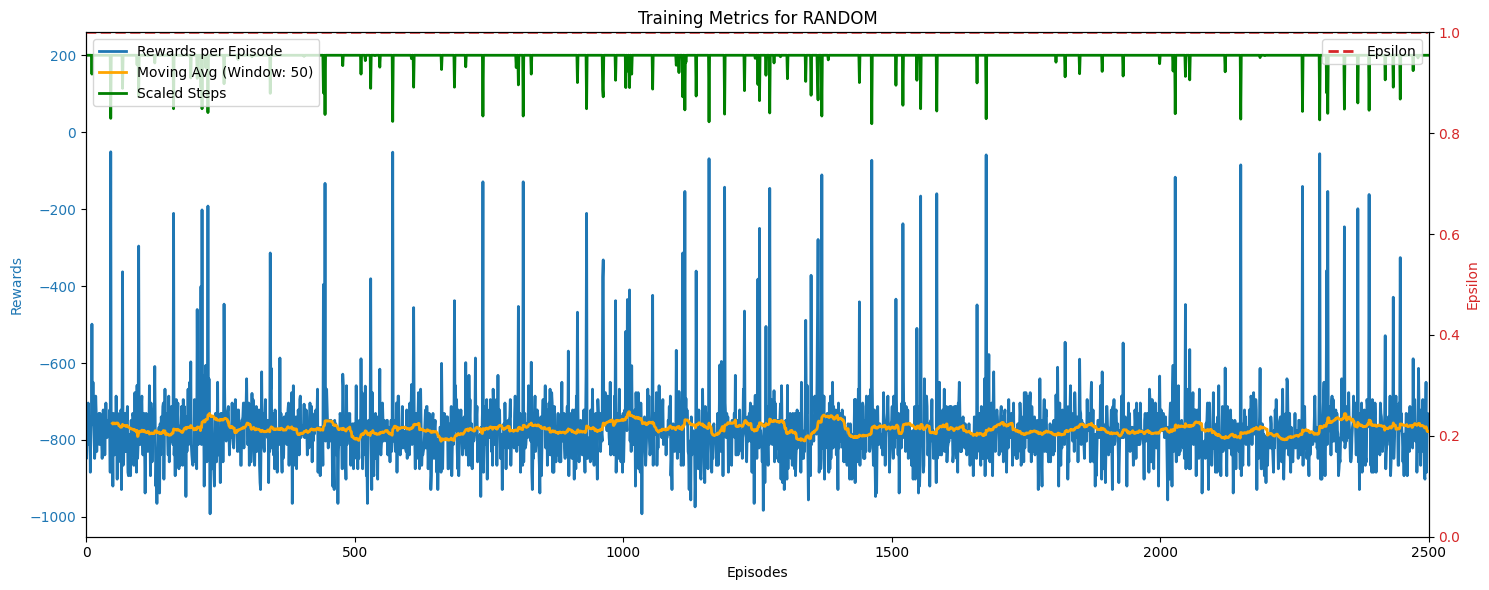

In [11]:
metrics.plot_metric('random')

In [15]:
metrics['random'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.000000,2500.0,2500.000000
mean,-770.775200,196.623200,1.0,0.001380
std,102.841093,19.235021,0.0,0.000174
min,-992.000000,22.000000,1.0,0.000169
25%,-821.000000,200.000000,1.0,0.001284
50%,-785.000000,200.000000,1.0,0.001454
75%,-740.000000,200.000000,1.0,0.001471
max,-51.000000,200.000000,1.0,0.001743


In [16]:
Video('./static/movies/random/rl-video-episode-0.mp4')

# Heuristic Policy

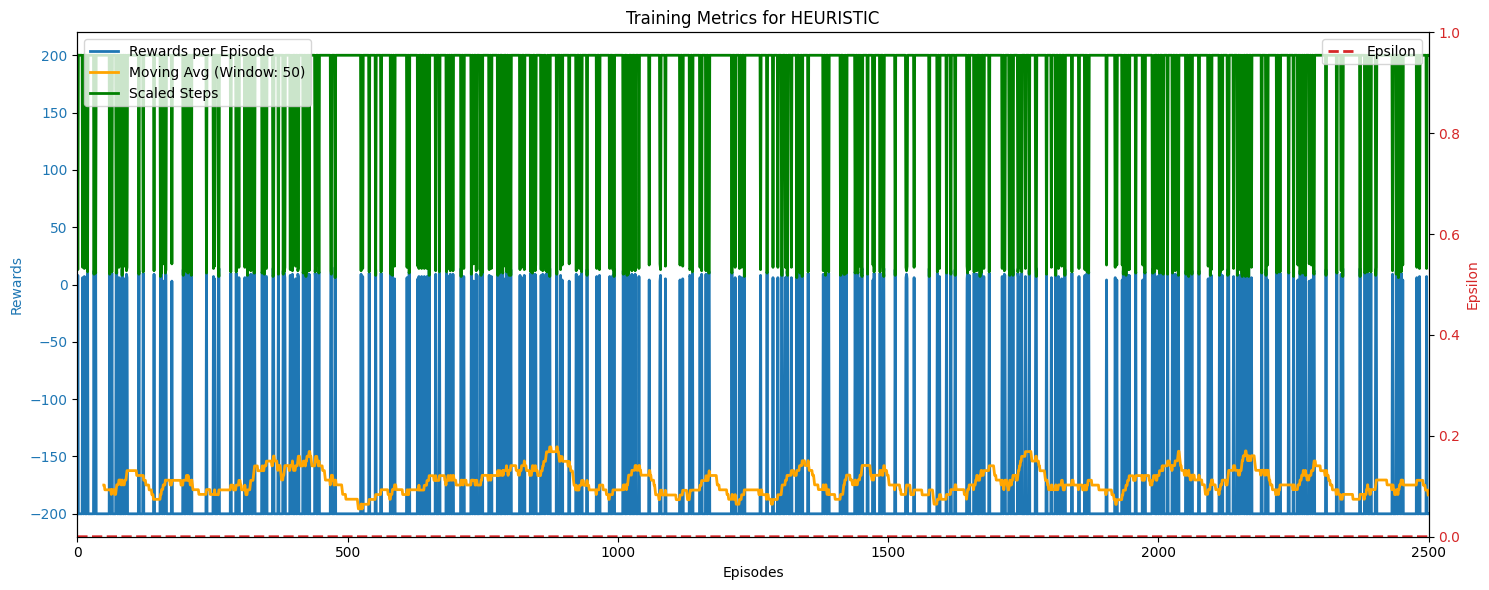

In [17]:
metrics.plot_metric('heuristic')

In [18]:
metrics['heuristic'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.00000,2500.0,2500.000000
mean,-172.279200,175.05960,0.0,0.001107
std,70.983868,63.86595,0.0,0.000417
min,-200.000000,6.00000,0.0,0.000045
25%,-200.000000,200.00000,0.0,0.001108
50%,-200.000000,200.00000,0.0,0.001306
75%,-200.000000,200.00000,0.0,0.001365
max,15.000000,200.00000,0.0,0.001548


In [19]:
Video('./static/movies/heuristic/rl-video-episode-0.mp4')

# Q-Learning Policy

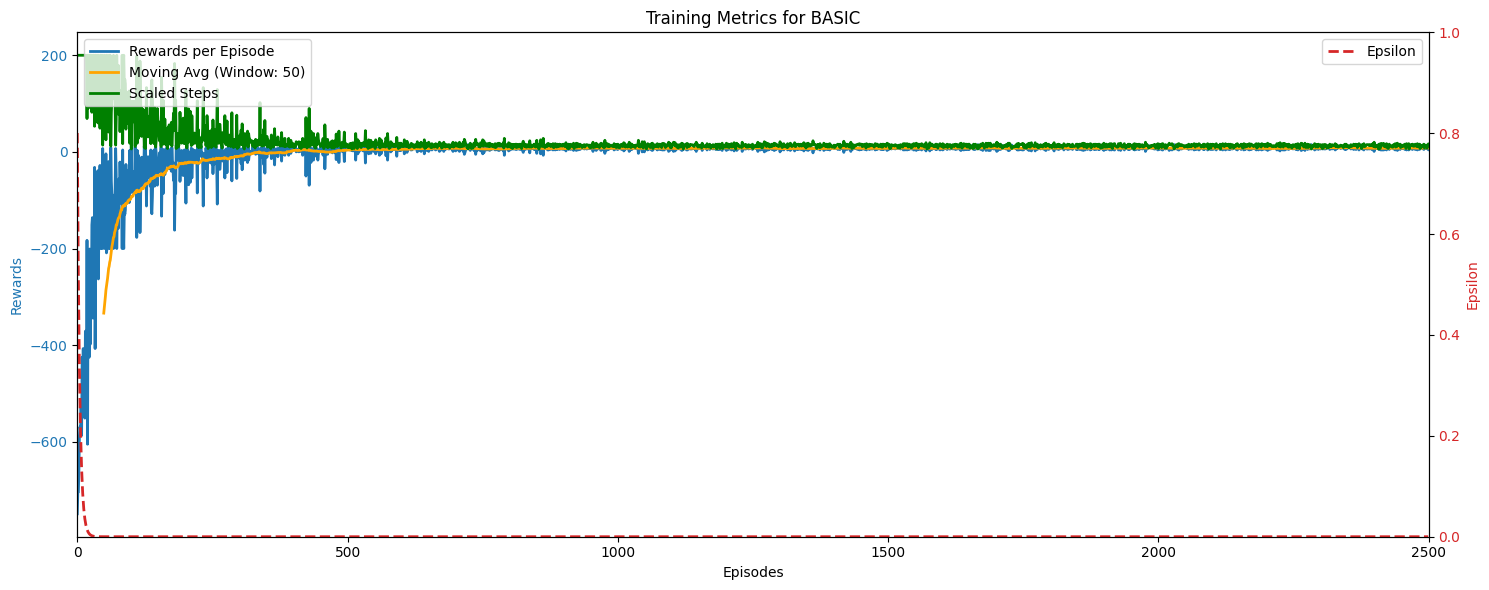

In [20]:
metrics.plot_metric('basic')

In [21]:
metrics['basic'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.000000,2.500000e+03,2500.000000
mean,-4.451600,21.674000,1.604257e-03,0.000160
std,59.429599,31.236793,2.666316e-02,0.000226
min,-749.000000,6.000000,2.001650e-242,0.000047
25%,5.000000,12.000000,5.056072e-182,0.000089
50%,7.000000,14.000000,1.273618e-121,0.000103
75%,9.000000,16.000000,3.198370e-61,0.000123
max,15.000000,200.000000,8.004248e-01,0.001778


In [22]:
Video('./static/movies/basic/rl-video-episode-0.mp4')

# SARSA Policy

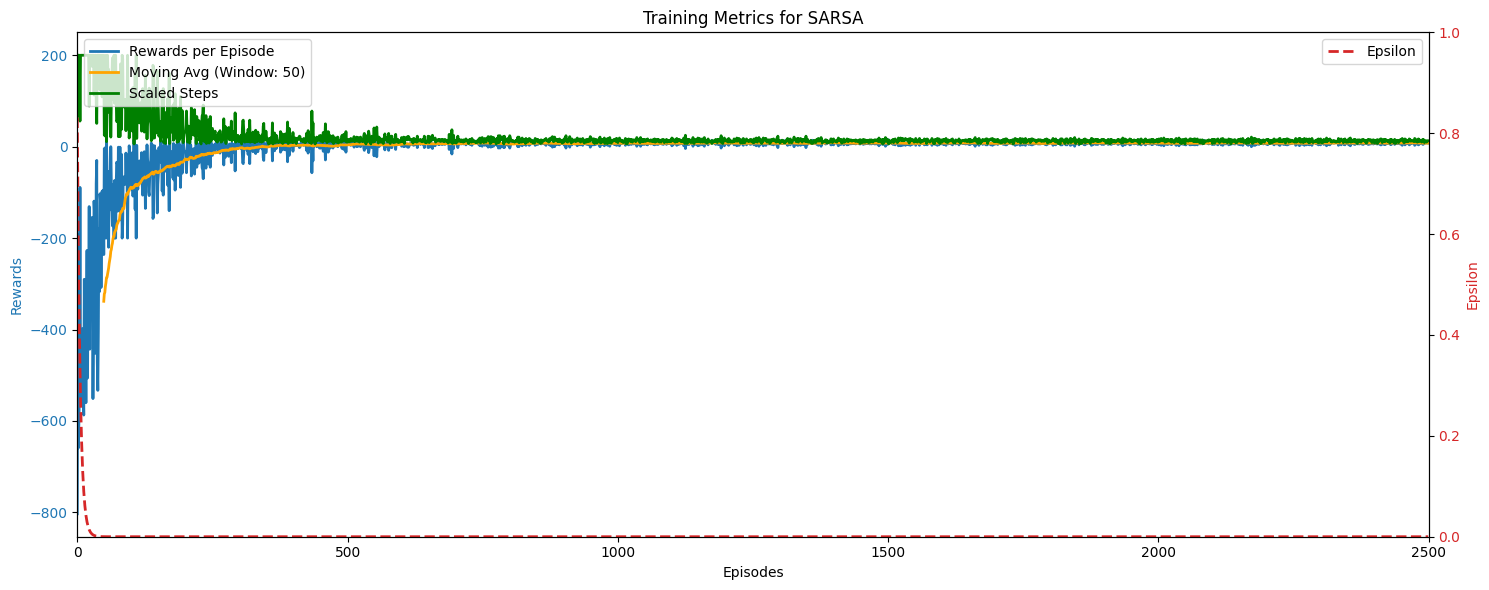

In [23]:
metrics.plot_metric('sarsa')

In [24]:
metrics['sarsa'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.000000,2.500000e+03,2500.000000
mean,-4.378000,21.654400,1.962597e-03,0.000174
std,58.832498,31.302008,2.978338e-02,0.000253
min,-803.000000,6.000000,4.015422e-202,0.000051
25%,5.000000,11.000000,8.590451e-152,0.000093
50%,7.000000,14.000000,1.834221e-101,0.000112
75%,10.000000,16.000000,3.908027e-51,0.000133
max,15.000000,200.000000,8.306948e-01,0.002206


In [25]:
Video('./static/movies/sarsa/rl-video-episode-0.mp4')

# Deep Q Network

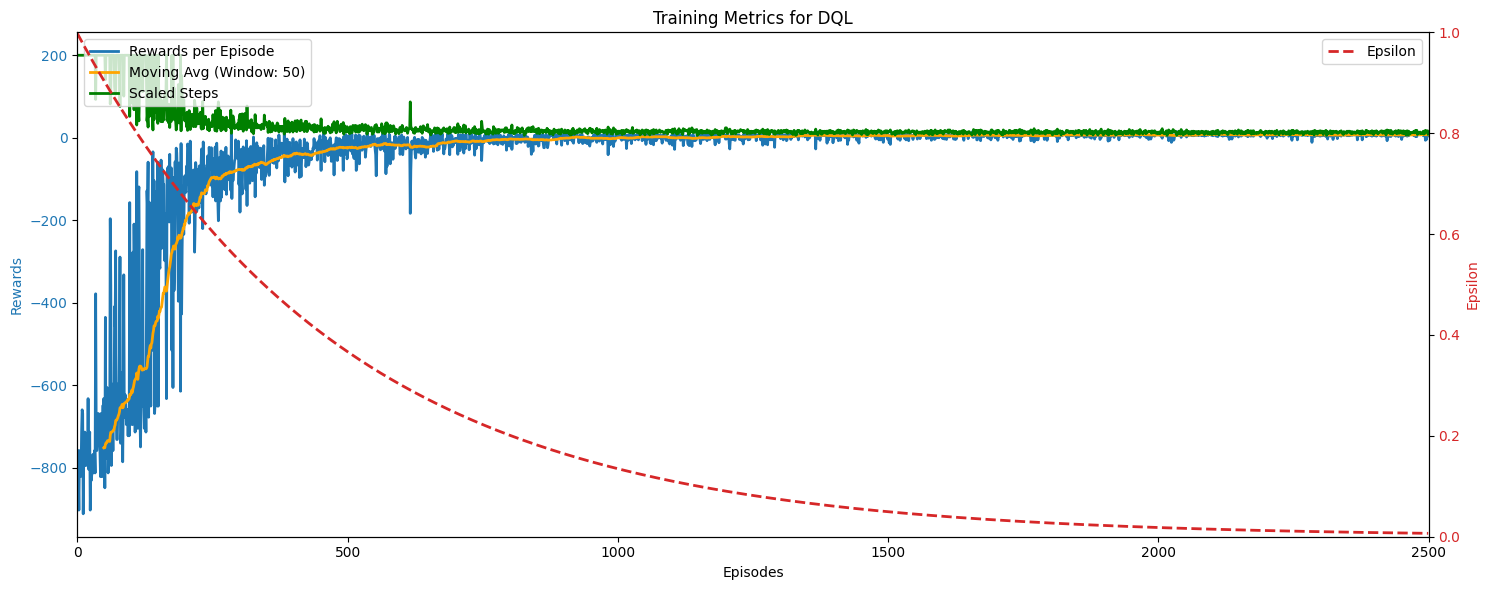

In [26]:
metrics.plot_metric('dql')

In [27]:
metrics['dql'].describe()

,rewards,steps,epsilon,time
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,-45.474000,27.468000,0.198262,0.066063
std,157.068026,41.237657,0.245789,0.070818
min,-911.000000,6.000000,0.006704,0.001433
25%,-13.000000,13.000000,0.023418,0.039492
50%,4.000000,16.000000,0.081798,0.048150
75%,8.000000,20.000000,0.285717,0.057368
max,15.000000,200.000000,0.998000,1.260465


In [28]:
Video('./static/movies/dql/rl-video-episode-0.mp4')

# Model comparison against Heuristic & Random Policy

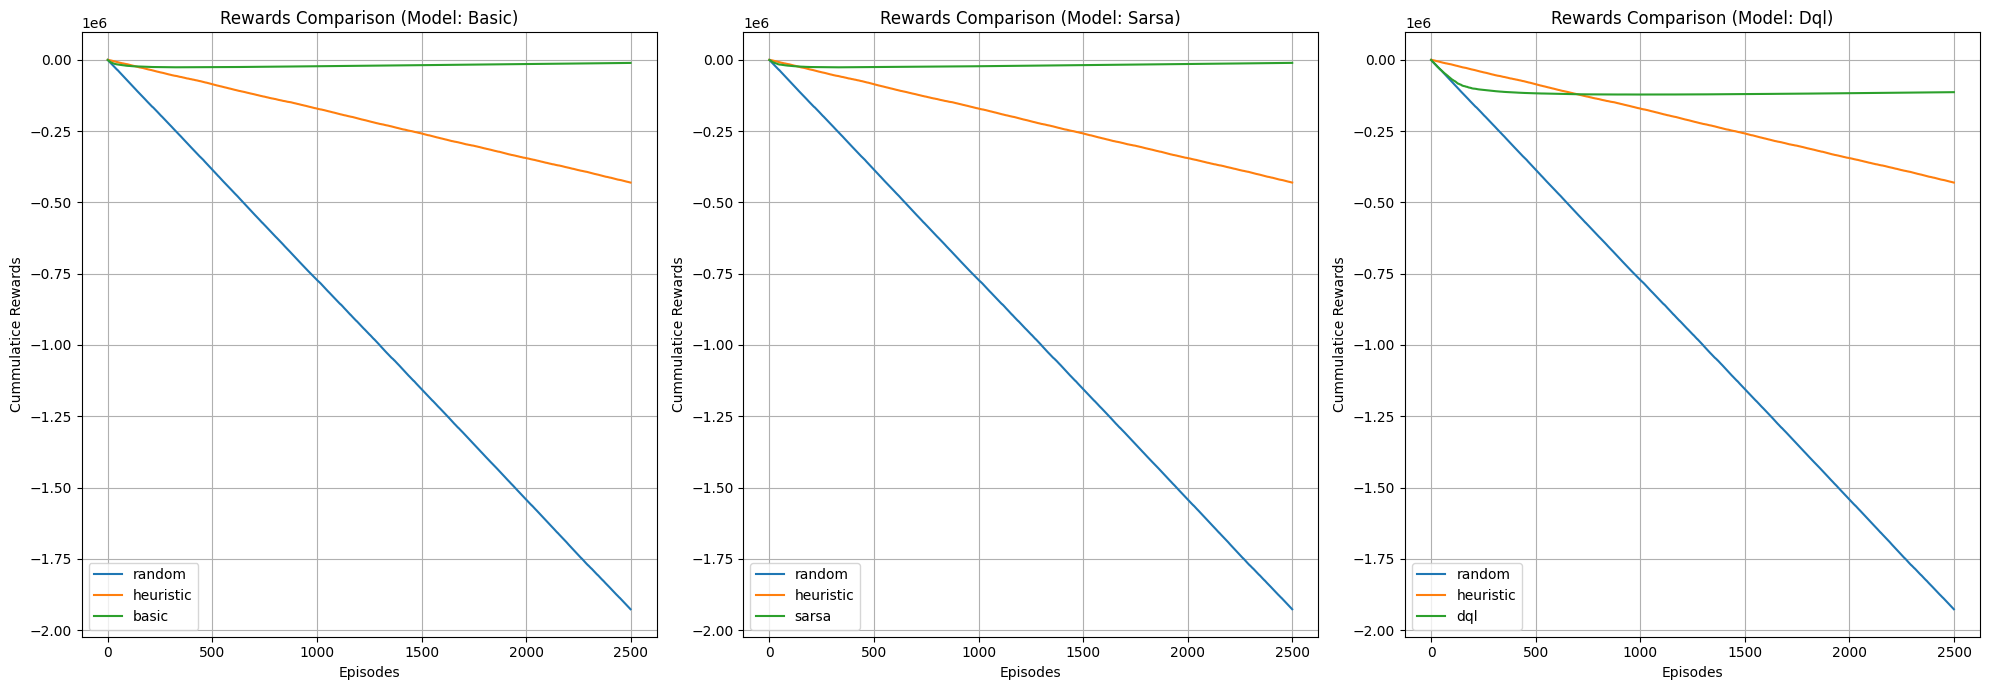

In [29]:
metrics.compare_rewards(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

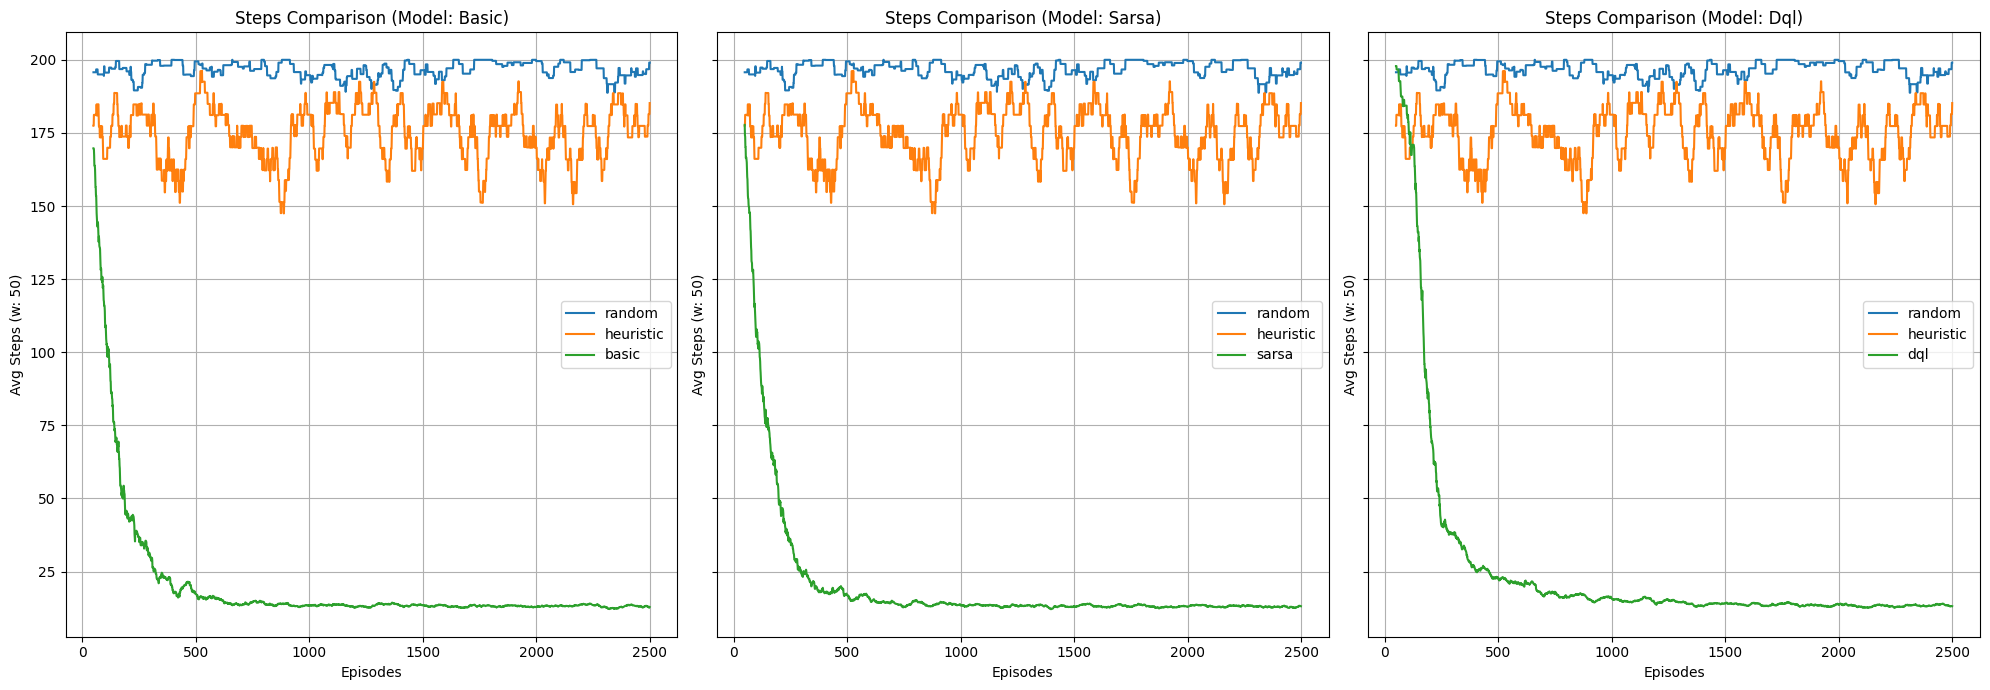

In [30]:
metrics.compare_steps(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

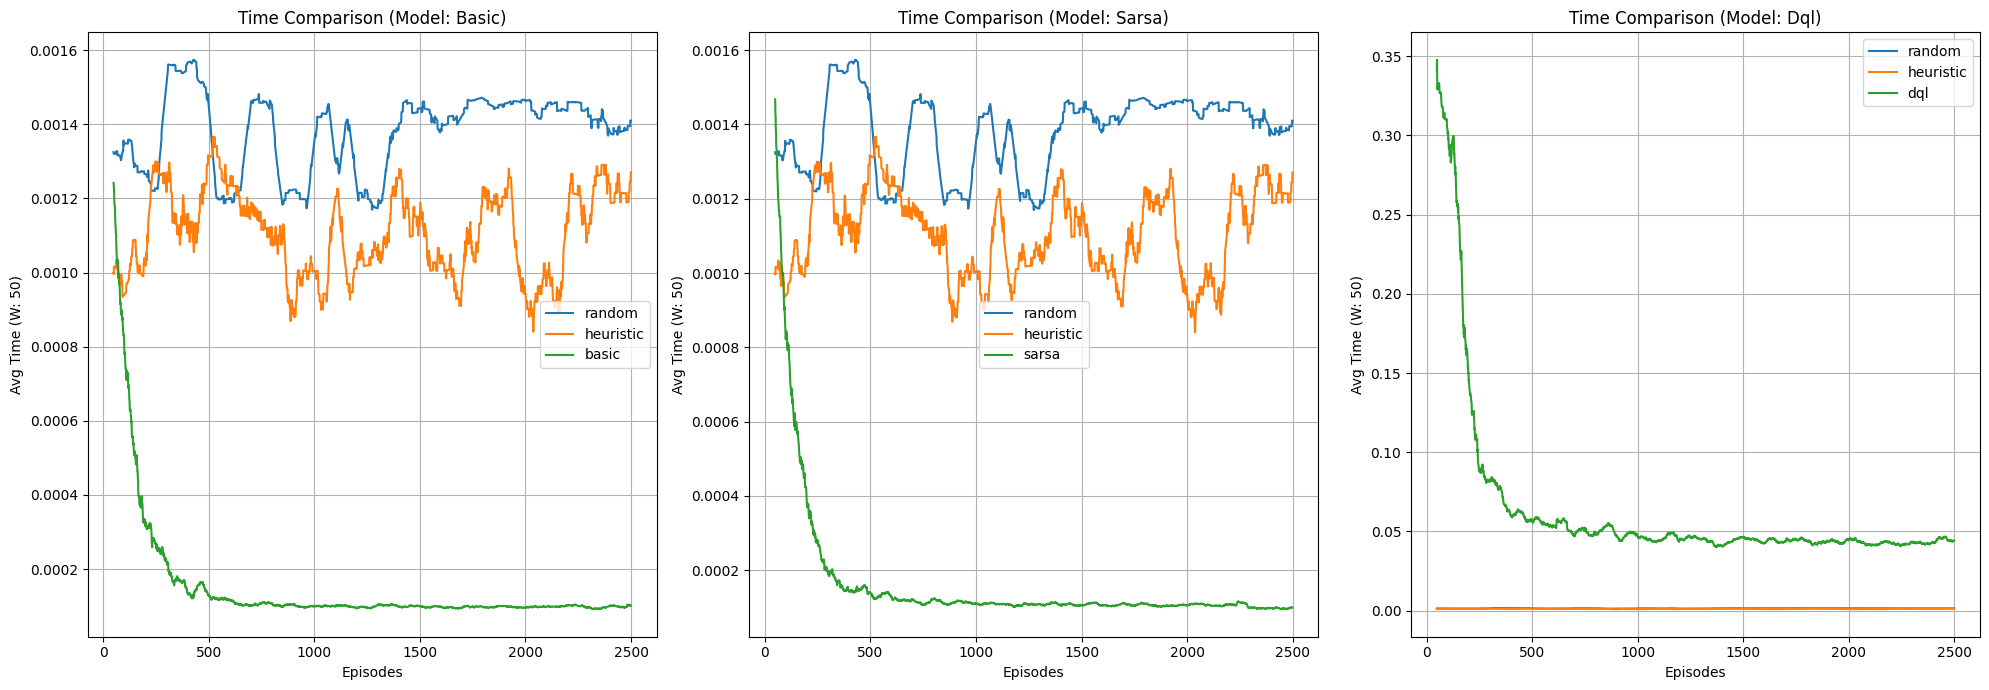

In [31]:
metrics.compare_time(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

# Train the agents yourself.
If you want to train the agents yourself, feel free to do so by running the cell below. This will update the saved weight & metrics, thus if you re-run this notebook, the analysis / graphs will probably differ a bit.

**NB: Make sure to uncomment the train function first then**.

Feel free to adjust the number of episodes by tweaking the --episodes param.

In [34]:
import train
from utils import create_progress_tracker
N_EPISODES = 2_500
N_RECORD = 3

for name, agent in agents.items():
    metrics = agent.train(N_EPISODES, 200, create_progress_tracker(name.upper()))
    metrics.save(f'./static/metrics/{name}.csv')
    agent.record_video(N_RECORD, f'./static/movies/{name}')

RANDOM


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


HEURISTIC


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/heuristic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


BASIC
SARSA0/2500|##################################################|100.0% Complete. Elapsed 0.4s.


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/basic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/sarsa folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


DQL


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/dql folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
